In [1]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import matplotlib.pyplot as plt

In [11]:
df = pd.read_json('bgg_data_clean.json',orient='split')
df.head(5)

,year,age,num_players,duration,mechanics,categories,families,poll_age,poll_numpl,num_rated,rating,bayes_rating,owned
387,2000,10,"[3, 7]","[45.0, 45.0, 45.0]",[Hand Management],"[Bluffing, Card Game]",[Series: Blue Games (Descartes)],"[[2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [8, 0...","[[1, [0, 0, 4]], [2, [0, 0, 4]], [3, [0, 6, 0]...",337,5.81844,5.55090,697
475,2000,12,"[2, 5]","[90.0, 45.0, 90.0]","[Auction, Card Drafting, Hand Management, Netw...","[Bluffing, Political]","[Cities: Agra (India), Country: India, Series:...","[[2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [8, 1...","[[1, [0, 0, 84]], [2, [0, 14, 82]], [3, [13, 6...",7149,7.27751,6.93109,8569
478,2000,10,"[2, 8]","[60.0, 20.0, 60.0]","[Action Drafting, Card Drafting, Drafting, Los...","[Bluffing, Card Game, City Building, Deduction...","[Mechanism: Tableau Building, Series: Fantasy ...","[[2, 0], [3, 0], [4, 0], [5, 0], [6, 14], [8, ...","[[1, [1, 4, 612]], [2, [179, 313, 423]], [3, [...",49176,7.07999,6.97364,65605
481,2000,12,"[2, 4]","[60.0, 60.0, 60.0]","[Area Majority / Influence, Dice Rolling, Hand...","[Abstract Strategy, Medieval, Territory Building]",[Digital Implementations: Yucata],"[[2, 0], [3, 0], [4, 0], [5, 1], [6, 0], [8, 0...","[[1, [0, 0, 54]], [2, [35, 54, 7]], [3, [58, 3...",3429,6.81879,6.38725,3909
490,2000,12,"[2, 6]","[60.0, 60.0, 60.0]","[Dice Rolling, Hexagon Grid]","[Fantasy, Mythology, Print & Play, Wargame]",[],"[[2, 0], [3, 0], [4, 0], [5, 0], [6, 1], [8, 4...","[[1, [0, 2, 2]], [2, [8, 3, 0]], [3, [1, 6, 3]...",262,7.70292,5.65154,340


In [12]:
class DictEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        for xs in X:
            yield { x: 1 for x in xs }

In [13]:
binary_encoder = Pipeline([
    ('encode',   DictEncoder()),
    ('vectorize',DictVectorizer(sparse=False))
])
X_all = Pipeline([
    ('attrs',ColumnTransformer([
        ('mechanics',binary_encoder,'mechanics'),
        ('categories',binary_encoder,'categories')
    ]))
]).fit_transform(df)
X_all

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
class ScaleRatingByYear(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.m = {
            key: vals for key,*vals in
            X.groupby('year').agg({'rating':['mean','std']}).to_records()
        }
        return self
    def transform(self, X):
        def scale(x):
            mean, std = self.m[x[0]]
            return (x[1]-mean)/std
        return X[['year','rating']].apply(scale,axis=1)

In [15]:
y_all = ScaleRatingByYear().fit_transform(df).to_numpy()

In [16]:
X_pca = PCA(n_components=64).fit_transform(X_all)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_all, test_size=0.35, random_state=123)

In [14]:
RandomForestRegressor??

In [18]:
forest = RandomForestRegressor(n_estimators=1000, max_depth=8, max_features=10, n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, max_features=10, n_estimators=1000,
                      n_jobs=-1)

In [19]:
forest.score(X_test, y_test)

0.4297125704681295

In [53]:
models = [
    RandomForestRegressor(
        n_estimators=1000, max_depth=x, max_features=10, n_jobs=-1
    ).fit(X_train, y_train)
    for x in range(2,16)
]

train_errors = []
test_errors = []
for model in models:
    train_errors.append(metrics.mean_squared_error(y_train, model.predict(X_train)))
    test_errors.append(metrics.mean_squared_error(y_test, model.predict(X_test)))

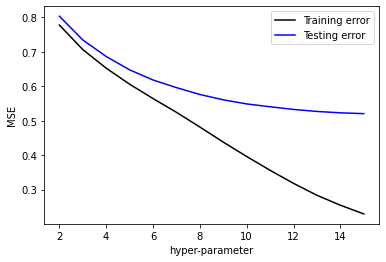

In [55]:
plt.plot(range(2,16), train_errors, 'k-', label='Training error')
plt.plot(range(2,16), test_errors, 'b-', label='Testing error')
plt.xlabel('hyper-parameter')
plt.ylabel('MSE')
plt.legend(loc='upper right')

In [ ]:
class Predictor():
    def __init__(self,pca):
        self.pca = pca